In [3]:

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt


#name columns according to the given name 
df= pd.read_csv(r'sample_test.csv', index_col=False,names=['type','sflow_agent_addr',
'inputPort','outputPort','src_MAC','dst_MAC','ethernet_type','in_vlan','out_vlan',
'src_IP','dst_IP','IP_Protocol','ip_tos','ip_ttl','udp_src_port','udp_dst_port',
'tcp_flags','packet_size','IP_size','sampling_rate'])

C:\Users\KHANTZ~1\AppData\Local\Temp/ipykernel_30900/1896186391.py:7: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df= pd.read_csv(r'sample_test.csv', index_col=False,names=['type','sflow_agent_addr',


# Frequency Analysis

## Top 5 Talkers&Listeners, Top Protocols


In [7]:
top5_talkers_ip = df['src_IP'].value_counts()[:5]
top5_listeners_ip = df['dst_IP'].value_counts()[:5]

tcp_count = df['IP_Protocol'].value_counts().get(6)
udp_count = df['IP_Protocol'].value_counts().get(17)
top3_IP_Protocols = df['IP_Protocol'].value_counts()[:3]

top5_apps_protocol = df['udp_dst_port'].value_counts()[:5]

total_traffic = df['IP_size'].sum()

print('Top 5 Talkers (IP):')
print(top5_talkers_ip)
print('\n')
   
print('Top 5 Listeners (IP):')
print(top5_listeners_ip)
print('\n')

print('Top 3 IP Protocols:')
print(top3_IP_Protocols)
print('\n')

print('Top 5 Application Protocols:')
print(top5_apps_protocol)
print('\n')

print('Total traffic: {} bytes\n'.format(total_traffic))

Top 5 Talkers (IP):
152.3.219.19       126
207.241.228.157     66
130.14.250.13       63
193.62.192.8        46
192.122.131.36      40
Name: src_IP, dtype: int64


Top 5 Listeners (IP):
198.71.44.98      126
103.37.198.100     98
210.48.222.9       66
137.132.228.15     50
202.21.159.244     38
Name: dst_IP, dtype: int64


Top 3 IP Protocols:
6     879
50    140
17    135
Name: IP_Protocol, dtype: int64


Top 5 Application Protocols:
443      234
0         82
56152     82
43930     45
80        37
Name: udp_dst_port, dtype: int64


Total traffic: 1079883 bytes



Top 5 communication Pairs

In [8]:
print('Additional stats:\n')

pairs={}
for index, row in df.iterrows():
    word1 = row['src_IP']+'/'+row['dst_IP']
    word2 = row['dst_IP']+'/'+row['src_IP']
    if word1 in pairs.keys():
        pairs[word1]+=1
    elif word2 in pairs.keys():
        pairs[word2]+=1
    else:
        pairs[word1]=1

pairs_sorted = sorted([(k,v) for k,v in pairs.items()], key= lambda x: x[1], reverse=True)

print('Top 5 communication pairs:\n{}\n'.format(pairs_sorted[:5]))

Additional stats:

Top 5 communication pairs:
[('152.3.219.19/198.71.44.98', 137), ('193.62.192.8/137.132.228.15', 81), ('207.241.228.157/210.48.222.9', 79), ('103.37.198.100/130.14.250.13', 70), ('216.58.203.234/192.122.131.36', 47)]



Network Visualization 

Network visualised:



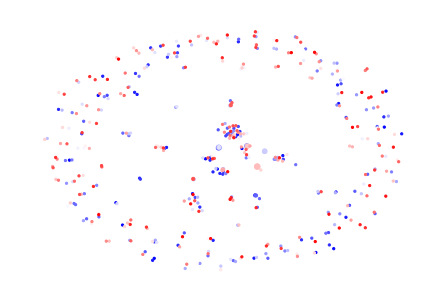

In [9]:
G = nx.Graph()
nodes = list(set(df['src_IP'].tolist()+df['dst_IP'].tolist())) #creating nodes
G.add_nodes_from(nodes)
for (p,n) in pairs_sorted:
    G.add_edge(p.split('/')[0], p.split('/')[1], weight=n)
size = []
for node in nodes:
    if G.degree(node, weight='weight')<25:
        #color.append('g')
        size.append(5)
    elif G.degree(node, weight='weight')<50:
        #color.append('b')
        size.append(10)
    elif G.degree(node, weight='weight')<75:
        #color.append('c')
        size.append(15)
    elif G.degree(node, weight='weight')<100:
        #color.append('y')
        size.append(20)
    elif G.degree(node, weight='weight')<125:
        #color.append('m')
        size.append(25)
    else:
        #color.append('r')
        size.append(30)
edges = G.edges()
weights = [G[u][v]['weight']/500 for u,v in edges]
print('Network visualised:\n')
nx.draw_spring(G, node_size=size, node_color=range(len(nodes)), width=weights, cmap=plt.cm.bwr)

# Geospatial Visualization

In [11]:
df1 = df.loc[:, ('src_IP','dst_IP')]
df1.head()


,src_IP,dst_IP
0,152.3.219.19,198.71.44.98
1,152.3.219.19,198.71.44.98
2,152.3.219.19,198.71.44.98
3,152.3.219.19,198.71.44.98
4,152.3.219.19,198.71.44.98


In [13]:

import requests
import ipaddress
ips = list(set(df1['src_IP'].tolist()+df1['dst_IP'].tolist()))
print(len(ips))
valid_ips = []
for ip in ips:
    try:
        ipaddress.ip_address(ip)
        valid_ips.append(ip)
    except:
        pass
print(len(valid_ips))

428
379


Batch Ip geolocation look up via ip-api.com

In [29]:
res = requests.post("http://ip-api.com/batch",json=valid_ips[:100]).json()
res = pd.DataFrame(res)

In [30]:
d={}
for index, row in res.iterrows():
    d[res.at[index,'query']] = [res.at[index,'lat'],res.at[index,'lon'],res.at[index,'org'],res.at[index,'countryCode']]

In [31]:
res = requests.post("http://ip-api.com/batch",json=valid_ips[100:200]).json()
res = pd.DataFrame(res)

In [32]:
for index, row in res.iterrows():
    d[res.at[index,'query']] = [res.at[index,'lat'],res.at[index,'lon'],res.at[index,'org'],res.at[index,'countryCode']]

In [33]:
res = requests.post("http://ip-api.com/batch",json=valid_ips[200:300]).json()
res = pd.DataFrame(res)

In [34]:
for index, row in res.iterrows():
    d[res.at[index,'query']] = [res.at[index,'lat'],res.at[index,'lon'],res.at[index,'org'],res.at[index,'countryCode']]

In [35]:
res = requests.post("http://ip-api.com/batch",json=valid_ips[300:]).json()
res = pd.DataFrame(res)

In [36]:
for index, row in res.iterrows():
    d[res.at[index,'query']] = [res.at[index,'lat'],res.at[index,'lon'],res.at[index,'org'],res.at[index,'countryCode']]

In [37]:
d

{'137.132.250.9': [1.29758, 103.773, 'National University of Singapore', 'SG'],
 '104.72.104.114': [42.3649, -71.0889, 'Akamai Technologies, Inc.', 'US'],
 '202.12.27.33': [35.3882, 139.428, 'WIDE', 'JP'],
 '137.132.208.204': [1.29758,
  103.773,
  'National University of Singapore',
  'SG'],
 '155.69.150.18': [1.34712, 103.68, 'Nanyang Technological University', 'SG'],
 '74.125.200.94': [37.422, -122.084, 'Google LLC', 'US'],
 '119.81.26.218': [1.35208, 103.82, 'SoftLayer Dutch Holdings B.V', 'SG'],
 '172.217.26.78': [3.15062, 101.67, 'Google LLC', 'MY'],
 '74.125.10.23': [1.35208, 103.82, 'Google LLC', 'SG'],
 '193.62.193.9': [52.1932, 0.1426, 'European Bioinformatics Institute', 'GB'],
 '150.65.7.130': [35.6906, 139.77, 'Japan150', 'JP'],
 '199.59.148.229': [37.7768, -122.416, 'Twitter Inc.', 'US'],
 '137.132.32.247': [1.29758,
  103.773,
  'National University of Singapore',
  'SG'],
 '192.122.131.14': [1.29961, 103.788, 'A*STAR', 'SG'],
 '173.194.22.203': [37.422, -122.084, 'Googl

In [38]:
ips = d.keys()

df1['src_lat'] = None
df1['src_lng'] = None
df1['dst_lat'] = None
df1['dst_lng'] = None

for index, row in df1.iterrows():
    
    src_ip = df1.at[index,'src_IP']
    if src_ip in ips:
        df1.at[index,'src_lat'] = d[src_ip][0]
        df1.at[index,'src_lng'] = d[src_ip][1]
    
    dst_ip = df1.at[index,'dst_IP']
    if dst_ip in ips:
        df1.at[index,'dst_lat'] = d[dst_ip][0]
        df1.at[index,'dst_lng'] = d[dst_ip][1]

df1= df1.dropna()

,src_IP,dst_IP,src_lat,src_lng,dst_lat,dst_lng
0,152.3.219.19,198.71.44.98,36.2963,-78.9379,42.2338,-83.7289
1,152.3.219.19,198.71.44.98,36.2963,-78.9379,42.2338,-83.7289
2,152.3.219.19,198.71.44.98,36.2963,-78.9379,42.2338,-83.7289
3,152.3.219.19,198.71.44.98,36.2963,-78.9379,42.2338,-83.7289
4,152.3.219.19,198.71.44.98,36.2963,-78.9379,42.2338,-83.7289


In [40]:
df1

,src_IP,dst_IP,src_lat,src_lng,dst_lat,dst_lng
0,152.3.219.19,198.71.44.98,36.2963,-78.9379,42.2338,-83.7289
1,152.3.219.19,198.71.44.98,36.2963,-78.9379,42.2338,-83.7289
2,152.3.219.19,198.71.44.98,36.2963,-78.9379,42.2338,-83.7289
3,152.3.219.19,198.71.44.98,36.2963,-78.9379,42.2338,-83.7289
4,152.3.219.19,198.71.44.98,36.2963,-78.9379,42.2338,-83.7289
...,...,...,...,...,...,...
1195,202.21.158.254,175.156.15.109,1.44292,103.785,1.32525,103.749
1196,123.136.64.58,165.21.83.88,1.33317,103.736,1.29199,103.807
1197,202.6.242.63,198.143.33.121,1.38755,103.844,34.0544,-118.2441
1198,171.67.76.38,137.132.3.10,37.4295,-122.178,1.29758,103.773


## World map visualization from opendatasoft


<AxesSubplot:>

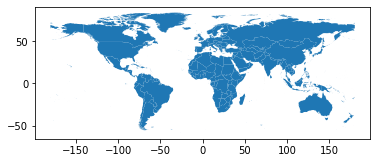

In [45]:
from shapely.geometry import Point, Polygon
import geopandas as gpd

world_map = gpd.read_file(r'.\world-admin-boundaries\world-administrative-boundaries.shp')
world_map.plot()

In [47]:
world_map.crs = "EPSG:4326"

<AxesSubplot:>

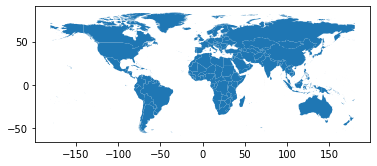

In [48]:
world_map.to_crs(epsg=4326).plot()

## Source IP Destination 

crs = {'init':'EPSG:4326'}
geo_src = [Point(xy) for xy in zip(df1['src_lng'], df1['src_lat'])]
geo_df = gpd.GeoDataFrame(df1, 
                          crs = crs, 
                          geometry = geo_src)


Text(0.5, 1.0, 'Source IP Geolocations')

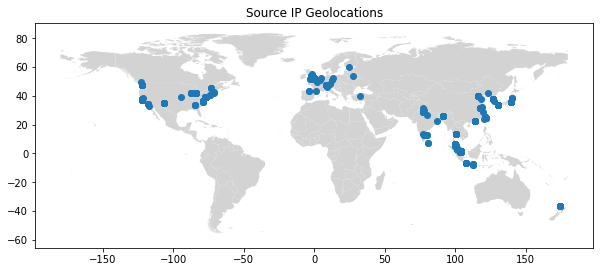

In [50]:
fig, ax = plt.subplots(figsize = (10,10))
world_map.to_crs(epsg=4326).plot(ax=ax, color='lightgrey')
geo_df.plot(ax=ax)
ax.set_title('Source IP Geolocations')

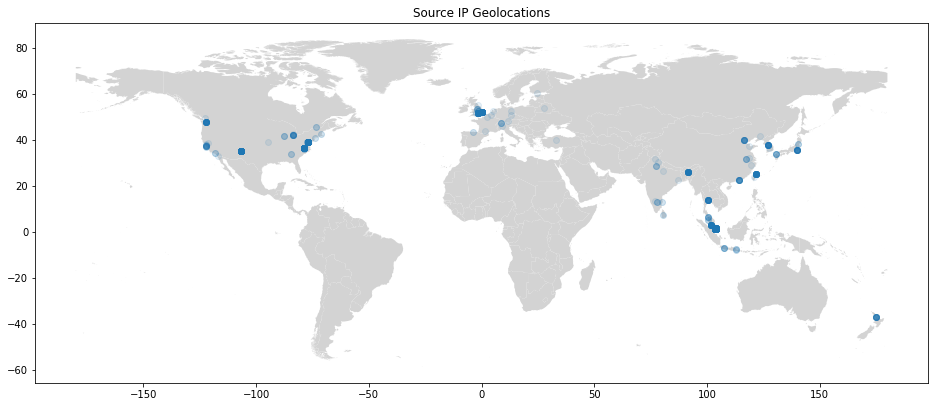

In [51]:
fig, ax = plt.subplots(figsize = (16,9))
world_map.to_crs(epsg=4326).plot(ax=ax, color='lightgrey')
geo_df.plot(ax=ax, alpha = .1 )
ax.set_title('Source IP Geolocations')
#plt.savefig('Source IP Geolocations')

Text(0.5, 1.0, 'Source IP Heatmap')

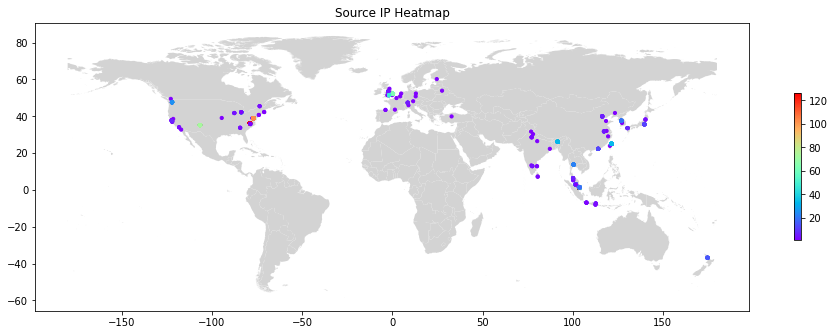

In [52]:
z={}
geo_df['count'] = 0
for index, row in geo_df.iterrows():
    geo = str(geo_df.at[index,'geometry'])
    if geo in z.keys():
        z[geo] = z[geo]+1
    else:
        z[geo] = 1

for index, row in geo_df.iterrows():
    geo = str(geo_df.at[index,'geometry'])
    geo_df.at[index,'count'] = z[geo]

fig, ax = plt.subplots(figsize = (16,9))
world_map.to_crs(epsg=4326).plot(ax=ax, color='lightgrey')
geo_df.plot(column = 'count', ax=ax, cmap = 'rainbow',
            legend = True, legend_kwds={'shrink': 0.3}, 
            markersize = 10)
ax.set_title('Source IP Heatmap')
#plt.savefig('Source IP Heat Map')

## Destination IP Visualization 

In [53]:
crs = {'init':'EPSG:4326'}
geo_dst = [Point(xy) for xy in zip(df1['dst_lng'], df1['dst_lat'])]
geo_df1 = gpd.GeoDataFrame(df1, 
                          crs = crs, 
                          geometry = geo_dst)

C:\Users\Khant Zayar\anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Text(0.5, 1.0, 'Destination IP Geolocations')

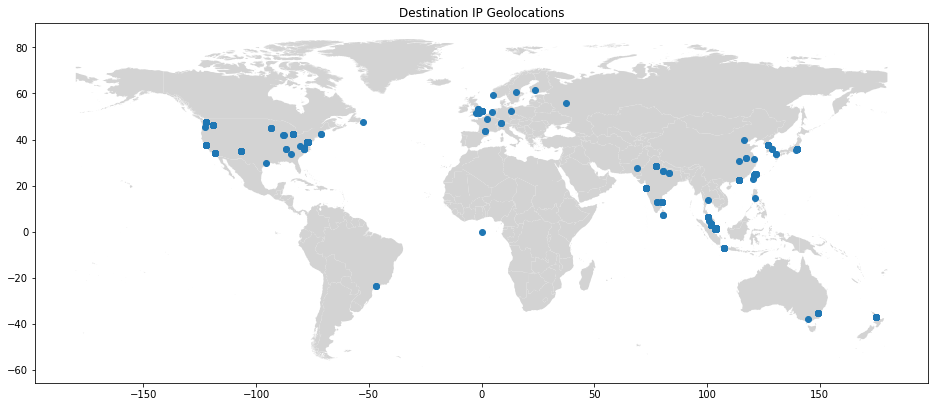

In [54]:
fig, ax = plt.subplots(figsize = (16,9))
world_map.to_crs(epsg=4326).plot(ax=ax, color='lightgrey')
geo_df1.plot(ax=ax)
ax.set_title('Destination IP Geolocations')

Text(0.5, 1.0, 'Destination IP Geolocations')

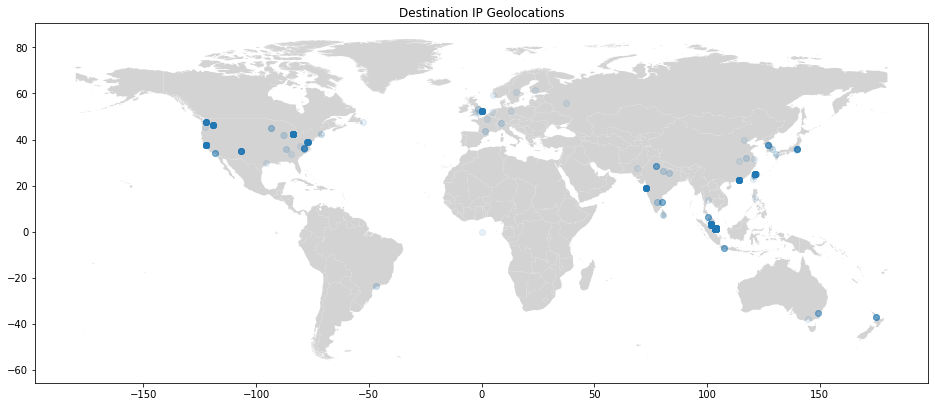

In [55]:
fig, ax = plt.subplots(figsize = (16,9))
world_map.to_crs(epsg=4326).plot(ax=ax, color='lightgrey')
geo_df1.plot(ax=ax, alpha = .1 )
ax.set_title('Destination IP Geolocations')
#plt.savefig('Destination IP Geolocations')

Text(0.5, 1.0, 'Destination IP Heatmap')

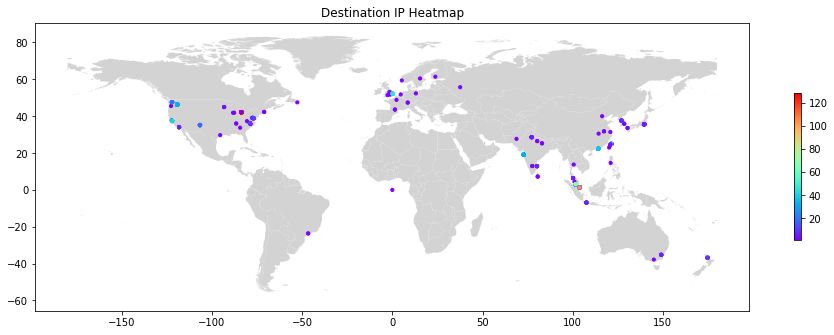

In [56]:
z={}
geo_df1['count'] = 0
for index, row in geo_df1.iterrows():
    geo = str(geo_df1.at[index,'geometry'])
    if geo in z.keys():
        z[geo] = z[geo]+1
    else:
        z[geo] = 1

for index, row in geo_df1.iterrows():
    geo = str(geo_df1.at[index,'geometry'])
    geo_df1.at[index,'count'] = z[geo]

fig, ax = plt.subplots(figsize = (16,9))
world_map.to_crs(epsg=4326).plot(ax=ax, color='lightgrey')
geo_df1.plot(column = 'count', ax=ax, cmap = 'rainbow',
            legend = True, legend_kwds={'shrink': 0.3}, 
            markersize = 10)
ax.set_title('Destination IP Heatmap')
#plt.savefig('Destination IP Heat Map')

Overall Geospatial Visualization 

In [57]:
ips = df1['src_IP'].tolist()+df1['dst_IP'].tolist()
lats = df1['src_lat'].tolist()+df1['dst_lat'].tolist()
lngs = df1['src_lng'].tolist()+df1['dst_lng'].tolist()

df2 = pd.DataFrame(
    {'ip': ips,
     'lat': lats,
     'lng': lngs
    })

In [58]:
crs = {'init':'EPSG:4326'}
geo_dst = [Point(xy) for xy in zip(df2['lng'], df2['lat'])]
geo_df2 = gpd.GeoDataFrame(df2, 
                          crs = crs, 
                          geometry = geo_dst)

Text(0.5, 1.0, 'Overall IP Geolocations')

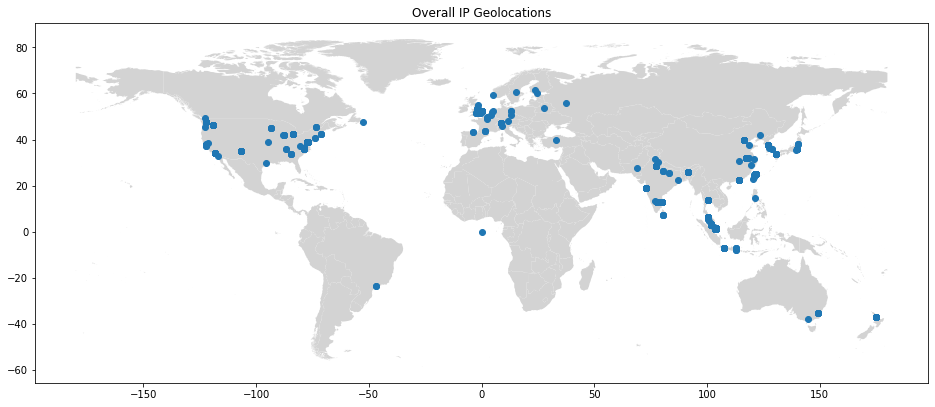

In [59]:
fig, ax = plt.subplots(figsize = (16,9))
world_map.to_crs(epsg=4326).plot(ax=ax, color='lightgrey')
geo_df2.plot(ax=ax)
ax.set_title('Overall IP Geolocations')

Text(0.5, 1.0, 'Overall IP Geolocations')

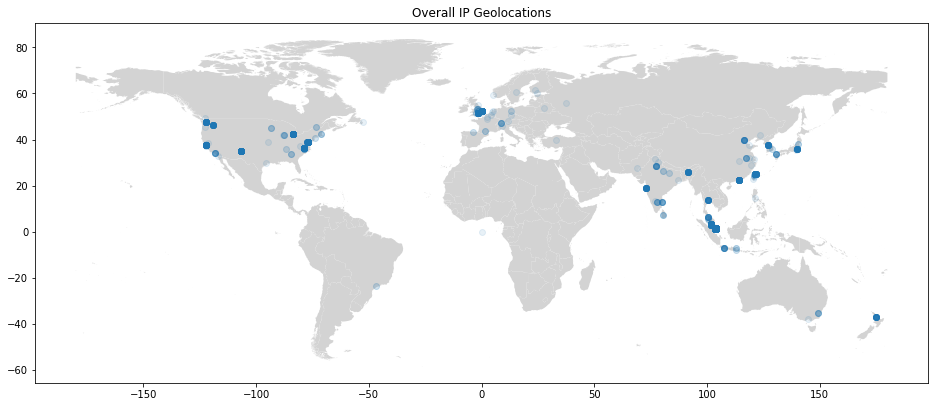

In [60]:
fig, ax = plt.subplots(figsize = (16,9))
world_map.to_crs(epsg=4326).plot(ax=ax, color='lightgrey')
geo_df2.plot(ax=ax, alpha = .1 )
ax.set_title('Overall IP Geolocations')
#plt.savefig('Overall IP Geolocations')

Text(0.5, 1.0, 'Overall IP Heatmap')

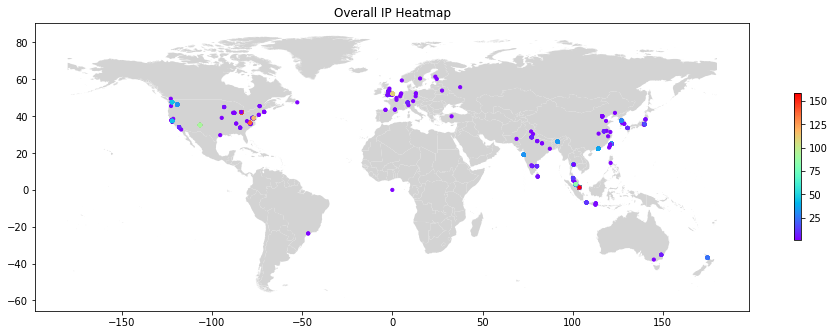

In [61]:
z={}
geo_df2['count'] = 0
for index, row in geo_df2.iterrows():
    geo = str(geo_df2.at[index,'geometry'])
    if geo in z.keys():
        z[geo] = z[geo]+1
    else:
        z[geo] = 1

for index, row in geo_df2.iterrows():
    geo = str(geo_df2.at[index,'geometry'])
    geo_df2.at[index,'count'] = z[geo]

fig, ax = plt.subplots(figsize = (16,9))
world_map.to_crs(epsg=4326).plot(ax=ax, color='lightgrey')
geo_df2.plot(column = 'count', ax=ax, cmap = 'rainbow',
            legend = True, legend_kwds={'shrink': 0.3}, 
            markersize = 10)
ax.set_title('Overall IP Heatmap')
#plt.savefig('Overall IP Heat Map')

In [63]:
from pyvis.network import Network
G = nx.Graph()
ips = d.keys()
nodes = list(set(df['src_IP'].tolist()+df['dst_IP'].tolist())) #unique ips
for node in nodes:
    if node in ips:
        G.add_node(node,label=d[node][2],countryCode=d[node][3]) #add node, id=ip, label=org name

for (p,n) in pairs_sorted:
    G.add_edge(p.split('/')[0], p.split('/')[1], weight=n)

nt = Network(height='750px', width='100%', bgcolor='#222222', font_color='white', notebook=True)
nt.from_nx(G)
nt.show('network.html')

network.html


In [64]:
df3 = pd.DataFrame.from_dict(data=d, orient='index', columns=['lat','lng','org','cc'])
df3.index.name = 'ip'
df3

,lat,lng,org,cc
ip,,,,
137.132.250.9,1.29758,103.7730,National University of Singapore,SG
104.72.104.114,42.36490,-71.0889,"Akamai Technologies, Inc.",US
202.12.27.33,35.38820,139.4280,WIDE,JP
137.132.208.204,1.29758,103.7730,National University of Singapore,SG
155.69.150.18,1.34712,103.6800,Nanyang Technological University,SG
...,...,...,...,...
203.185.93.2,13.75860,100.5410,National Electronics and Computer Technology C...,TH
123.136.65.217,1.33317,103.7360,A Star,SG
137.132.243.174,1.29758,103.7730,National University of Singapore,SG


In [65]:
df3.to_csv('ip_lookup.csv')
